# Установка необходимых библиотек

In [ ]:
!pip install gensim
!pip install catboost
!pip install matplotlib==3.2.0 # Такая версия не выдает ошибку при отрисовке матрицы ошибок с нулевым количеством предсказаний в одном из классов
!pip install --upgrade pip
!pip install sentencepiece datasets
! pip install -U accelerate
! pip install -U transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.5/98.5 MB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.5/40.5 MB 15.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for matplotlib: filename=matplotlib-3.2.0-cp310-cp310-linux_x86_64.whl size=11954411 sha256=80560a797f42bc9de8ad8257bb15c96325b3cc55f6a9cf74799284f97c2cb37c
  Stored in directory: /root/.cache/pip/wheels/58/0a/5e/8397500cf9bccc1e8dacd88d51b4fa9f2aa7e45557d97d5490
Successfully built matplotlib
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.7.1
    Uninstalling matplotlib-3.7.1:
      Successfully uninstalled matplotlib-3.7.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
mizani 0.9.3 requires matplotlib>=3.5.0, but you have matplotlib 3.2.0 which is incompatible.
plotnine 0.12.4 requires matplotlib>=3.6.0, but you

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 7.8 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 23.1.2
    Uninstalling pip-23.1.2:
      Successfully uninstalled pip-23.1.2
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 536.7/536.7 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.0/280.0 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 131.1/131.1 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.5/8.5 MB 35.6 MB/s eta 0:00:00
  Attempting uninstall: transformers
    Found existing installation: transformers 4.37.2
    Uninstalling transformers-4.37.2:
      Successfully uninstalled transformers-4.37.2


# Импорт библиотек

In [ ]:
# Для работы с файлами
import shutil
import json
import os

# Для работы с матрицами и таблицами
import numpy as np
import pandas as pd

# Для подсчета метрик
from sklearn.metrics import (
    cohen_kappa_score,
    explained_variance_score,
    mean_squared_error,
    confusion_matrix,
    ConfusionMatrixDisplay,
    classification_report
)
import scipy

# Отрисовка графиков и процесса обучения
import matplotlib.pyplot as plt
from tqdm import tqdm

# Для подключения к google-таблице с данными
from gspread import authorize
from oauth2client.service_account import ServiceAccountCredentials
scopes = ["https://spreadsheets.google.com/feeds",
                  "https://www.googleapis.com/auth/spreadsheets",
                  "https://www.googleapis.com/auth/drive",
                  "https://www.googleapis.com/auth/drive"]

from google.colab import drive

# Работа с текстом
import nltk
from nltk.corpus import stopwords
import string, re
from collections import Counter

# Кодирование текста
from gensim.models import KeyedVectors, Word2Vec
from sklearn.feature_extraction.text import TfidfVectorizer

# Импорт классических моделей
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn import svm
from sklearn.dummy import DummyRegressor

# Необходимые библиотеки для BERT
import transformers
import torch
from transformers import AutoModel, AutoTokenizer, AutoConfig, AutoModelForSequenceClassification
from transformers import DataCollatorWithPadding
from transformers import TrainingArguments, Trainer
from datasets import Dataset

# Деление на выборки для обучения
from sklearn.model_selection import train_test_split, KFold, GroupKFold

# Объявление функций
В данном разделе можно найти объявление функции, которые далее используются в ноутбуке

In [ ]:
def seed_everything(seed: int):
    import random, os
    import numpy as np
    import torch

    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

## Оценка качества моделей

In [ ]:
def calc_metrics(true: np.array, pred: np.array) -> dict:
    """Calculates all necesserary metrics

    Args:
        true (np.array): True ansers
        pred (np.array): Predicted answers

    Returns:
        dict: Dictionary with metrics
    """
    # Root of mean squared error
    rmse = np.sqrt(mean_squared_error(true, pred))

    # Explained variance score
    exp_var = explained_variance_score(true, pred)

    # Kappa score
    kappa = cohen_kappa_score(true, pred, weights="quadratic")

    # Pearson correlation coefficient
    r_1 = np.corrcoef(true, pred)[0, 1]

    # Spearman correlation coefficient
    rho_1 = scipy.stats.spearmanr(true, pred)[0]

    return {
        "rmse": rmse,
        "pearson_coeff": r_1,
        "spearman_coeff": rho_1,
        "explained_variance": exp_var,
        "kappa": kappa
        }

def display_confusion_matrix(y_true, y_pred, model_name: str) -> None:

  confusion_matrix_data = confusion_matrix(y_true, y_pred)
  class_names = sorted(np.unique(y_true))

  cm_display = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_data, display_labels=class_names)
  cm_display.plot()
  plt.title(model_name)
  plt.show()


def display_metrics(true: np.array, pred: np.array, model_name: str) -> None:
  true = true.astype(int)
  pred = pred.astype(int)

  # Prepare and display regression report string
  regression_metrics = calc_metrics(true, pred)
  regression_report = "Regression report:\n"
  for metric_name, metric_value in regression_metrics.items():
    regression_report += f"{metric_name}: {round(metric_value, 3)}\n"
  print(regression_report)

  # Display confusion matrix
  display_confusion_matrix(true, pred, model_name)

  # Display classification report
  print()
  print(classification_report(true, pred))

def clip_predictions(pred: np.array) -> np.array:
  pred_clip = np.where(pred < 2, pred, 2)
  pred_clip = np.where(pred_clip > 0, pred_clip, 0)
  pred_clip = np.round(pred_clip).astype(int)
  return pred_clip

def log_metrics(metrics: dict, model_name: str) -> None:
  global DF_METRICS
  metrics.update({"model_name": model_name})
  new_record = pd.DataFrame(metrics, index=[0])
  DF_METRICS = pd.concat([DF_METRICS, new_record], ignore_index=True)

## Загрузка данных

In [ ]:
def read_from_gsheet():
    cred = ServiceAccountCredentials.from_json_keyfile_name('/content/drive/MyDrive/movs_project/credentials_googlesheets.json', scopes)
    gc = authorize(cred)
    sheet = gc.open_by_url('https://docs.google.com/spreadsheets/d/1m0mc1H7ULIZ2HEkT4dha_XRmRjt0gWJ8aht_GJ2lxfw/edit#gid=0')
    ws = sheet.worksheet('Dataset')
    return pd.DataFrame(ws.get_all_records())

def drop_unwanted_data(df: pd.DataFrame):
    columns_to_drop = ['Comments', 'origin', 'task_image', 'score_image']
    columns = ['Solving a communicative task', 'Text structure', 'Use of English (for emails)', 'Lexis (essay)',
               'Grammatical accuracy (essay)', 'Punctuation and spelling (essay)']

    # Удаляем лишние столбцы (на данный момент)
    df = df.drop(columns=columns_to_drop)

    # Удаляем строки баллов, если там сожержатся другие значения, кроме int и float (избавимся от string)
    for column in columns:
        df[column] = pd.to_numeric(df[column], errors='coerce')

    return df

def split_types(df: pd.DataFrame):
    # Следующий этап - разделим на письма и эссе
    essay_df = df[df[' Type'] == 'Essay']
    email_df = df[df[' Type'] == 'Email']

    # и удалим лишние колонки для каждого типа
    essay_df = essay_df.drop(columns='Use of English (for emails)')
    email_df = email_df.drop(
        columns=['Lexis (essay)', 'Grammatical accuracy (essay)', 'Punctuation and spelling (essay)'])

    # Убираем NaN
    essay_df = essay_df.dropna()
    email_df = email_df.dropna()

    return essay_df, email_df

In [ ]:
def read_new_data(path: str, columns: list, text_col_name: str, target_col_name: str, origin_col_name: str, assigned_score: int, origin: str = "gpt") -> pd.DataFrame:
  new_data = pd.read_excel(path)

  if "Unnamed: 0" in new_data.columns:
    new_data = new_data.drop("Unnamed: 0", axis=1)

  new_data.columns = columns
  new_data[target_col_name] = assigned_score
  new_data[origin_col_name] = origin

  if text_col_name in new_data.columns:
    new_data = new_data.drop(text_col_name, axis=1).rename(columns={"GPT_Text":text_col_name})
  if "GPT_Question" in new_data.columns:
    new_data = new_data.drop("GPT_Question", axis=1)

  new_data[text_col_name] = new_data[text_col_name].replace({"\s+Explanation?([\s\S]*)": "", "\s+\---?([\s\S]*)": ""}, regex=True)

  return new_data

## Очистка / преобразование данных

In [ ]:
def get_main_section(s):
  text = re.search(r"Subject:([\s\S]*?)Write an? e-?mail", str(s))
  if text is not None:
    return text.group(1)
  else:
    return None

def rm_after_write_phrase(s):
  text = re.sub(r"Write an? e-?mail[\s\S]*", "", str(s))
  return text

def get_after_newline(s):
  text = re.search("\n[\s\S]*", s)
  if text is not None:
    return text.group()
  else:
    print(s)
    return None

def trim_questions(raw: pd.Series) -> pd.Series:
  full_questions = raw[raw.str.contains('You have received an email message', na=False)]
  trimmed_questions = full_questions.apply(get_main_section)
  trimmed_questions = trimmed_questions.str.replace("\n+", "\n", regex=True).str.strip()
  trimmed_questions = trimmed_questions.apply(get_after_newline)
  return trimmed_questions

def preprocess_dataset(df: pd.DataFrame, question_col_name: str, text_col_name: str, target_col_name: str, target_dtype="float32") -> pd.DataFrame:
  df = df[df[text_col_name].str.strip().astype(bool)] # Удалим строки с пустыми ответами
  df = df[~df[question_col_name].str.contains('[А-Яа-я]+', regex=True)] # Удалим строки с русскими символами в тексте задания
  df = df[df[question_col_name].notna()] # Удалим строки с NaN
  df = df[df[question_col_name] != ''] # Удалим строки с пустыми заданиями
  # df[text_col_name] = df[text_col_name].apply(lambda x: re.sub(r'[^A-Za-z\s]', ' ', str(x))) # Оставим только английские буквы

  # Оставляем строки с правильно поставленным баллом
  df = df[pd.to_numeric(df[target_col_name], errors='coerce').notna()]
  df[target_col_name] = df[target_col_name].astype(target_dtype)

  return df

def create_question_id_col(df: pd.DataFrame, question_col_name: str, question_id_col_name: str) -> pd.Series:
  # Создадим новую колонку с уникальным индексом для вопросов
  df[question_id_col_name] = df[question_col_name]

  # Обрежем условия заданий, оставив только часть с вопросами и предложение для ответа на вопрос
  trimmed_questions = trim_questions(df[question_col_name])
  df.loc[trimmed_questions.index, question_id_col_name] = trimmed_questions

  # Очистим ненужные символы и преобразуем к строчному регистру
  initial_questions_indx = df.index.difference(trimmed_questions.index)
  df.loc[initial_questions_indx, question_id_col_name] = df.loc[initial_questions_indx, question_id_col_name].apply(rm_after_write_phrase)
  df[question_id_col_name] = df[question_id_col_name].str.replace("[^A-Za-z\s-]", " ", regex=True).apply(lambda x: " ".join(x.split())).str.lower().str.strip()
  df[question_id_col_name] = pd.factorize(df[question_id_col_name])[0]

  return df[question_id_col_name]

def split_to_train_test(df: pd.DataFrame, question_id_col_name: str, target_col_name: str, origin_col_name: str, gen_data_prefix="gpt", n_questions=1, n_samples=1, random_state=42) -> tuple[pd.DataFrame, pd.DataFrame]:

  # Отделяем синтетические данные от реальных, чтобы синтетические не попали в отложенную выборку
  real_data = df[~df[origin_col_name].str.contains(gen_data_prefix)]

  question_id_value_counts = real_data[question_id_col_name].value_counts()
  questions_greater_than_n = question_id_value_counts[question_id_value_counts > n_questions].index.tolist()
  test_pool = real_data[real_data[question_id_col_name].isin(questions_greater_than_n)]
  test_pool = test_pool[test_pool[target_col_name] != 0] # Удалим все письма с нелувым баллом, чтобы не было пересечений далее

  test_samples = []
  for question_id in test_pool[question_id_col_name].unique():
    candidates = test_pool[test_pool[question_id_col_name] == question_id]
    test_samples.append(candidates.sample(n=n_samples, random_state=random_state))

  test_samples.append(real_data[real_data[target_col_name] == 0]) # Возьмем в тестовую выборку все письма с нулевым баллом
  test_data = pd.concat(test_samples, axis=0)

  train_index = df.index.difference(test_data.index)
  train_data = df.loc[train_index, :]

  return train_data, test_data

## Кодирование с помощью GENSIM


In [ ]:
def essay_to_wordlist(essay_v: str, remove_stopwords: bool) -> tuple:
    """Remove the tagged labels and word tokenize the sentence"""
    essay_v = re.sub("[^a-zA-Z]", " ", essay_v)
    words = essay_v.lower().split()
    if remove_stopwords:
        stops = set(stopwords.words("english"))
        words = [w for w in words if w not in stops]
    return words


def essay_to_sentences(essay_v: str, remove_stopwords: bool) -> list:
    """Sentence tokenize the essay and call essay_to_wordlist() for word tokenization."""
    tokenizer = nltk.data.load("tokenizers/punkt/english.pickle")
    raw_sentences = tokenizer.tokenize(essay_v.strip())
    sentences = []
    for raw_sentence in raw_sentences:
        if len(raw_sentence) > 0:
            sentences.append(essay_to_wordlist(raw_sentence, remove_stopwords))
    return sentences


def make_feature_vec(
    words: list, model: Word2Vec | KeyedVectors, num_features: int
) -> np.array:
    """Make ar from the words list of an Essay."""
    feature_vec = np.zeros((num_features,), dtype="float32")
    num_words = 0
    if hasattr(model, "wv"):
        index2word_set = set(model.wv.index_to_key)
    else:
        index2word_set = set(model.index_to_key)

    for word in words:
        if word in index2word_set:
            num_words += 1
            if hasattr(model, "wv"):
                feature_vec = np.add(feature_vec, model.wv[word])
            else:
                feature_vec = np.add(feature_vec, model[word])
    feature_vec = np.divide(feature_vec, num_words)
    return feature_vec


def get_avg_feature_vecs(
    essays: list, model: Word2Vec | KeyedVectors, num_features: int
) -> np.array:
    """Main function to generate the word vectors for word2vec model."""
    counter = 0
    essay_feature_vecs = np.zeros((len(essays), num_features), dtype="float32")
    for essay in essays:
        essay_feature_vecs[counter] = make_feature_vec(essay, model, num_features)
        counter += 1
    return essay_feature_vecs


def prep_train_data(train_data: pd.DataFrame, target_col_name: str, input_col_name: str, w2vec_path: str, num_features: int, window_size: int = 10, min_count: int = 40) -> tuple:
    """Prepare data for training

    Args:
        data (pd.DataFrame): Input raw dataframe

    Returns:
        tuple: Tuple of features np.array and answers np.array
    """
    nltk.download("punkt")
    nltk.download("stopwords")

    train_data = train_data.dropna(axis=1)
    scores = train_data[target_col_name]
    train_data = train_data[input_col_name]

    sentences = []

    for essay in train_data:
        sentences += essay_to_sentences(essay, remove_stopwords=False)
    model = Word2Vec(
        sentences,
        workers=8,
        vector_size=num_features,
        min_count=min_count,
        window=window_size,
        sample=0.001,
    )
    model.wv.save_word2vec_format(w2vec_path, binary=True)

    clean_train_essays = []

    for essay_text in train_data:
        clean_train_essays.append(essay_to_wordlist(essay_text, remove_stopwords=False))
    train_vectors = get_avg_feature_vecs(
        clean_train_essays, model, num_features
    )

    return np.array(train_vectors), np.array(scores)


def prep_test_data(test_data: pd.DataFrame, target_col_name: str, input_col_name: str, w2vec_path: str, num_features: int) -> np.array:
    """Prepare data for testing

    Args:
        data (pd.DataFrame): Input raw dataframe

    Returns:
        np.array: Features np.array
    """

    model = KeyedVectors.load_word2vec_format(w2vec_path, binary=True)

    test_data = test_data.dropna(axis=1)
    scores = test_data[target_col_name]
    test_data = test_data[input_col_name]

    sentences = []

    for essay in test_data:
        sentences += essay_to_sentences(essay, remove_stopwords=False)

    clean_test_essays = []
    for essay_text in test_data:
        clean_test_essays.append(essay_to_wordlist(essay_text, remove_stopwords=False))

    test_vectors = get_avg_feature_vecs(
        clean_test_essays, model, num_features
    )

    return np.array(test_vectors), np.array(scores)

## Кодирование с помощью GloVe

In [ ]:
def glove_essay_to_wordlist(essay_v: str, remove_stopwords: bool) -> tuple:
    """Remove the tagged labels and word tokenize the sentence"""
    essay_v = re.sub("[^a-zA-Z]", " ", essay_v)
    words = essay_v.lower().split()
    if remove_stopwords:
        stops = set(stopwords.words("english"))
        words = [w for w in words if w not in stops]
    return words


def glove_essay_to_sentences(essay_v: str, remove_stopwords: bool) -> list:
    """Sentence tokenize the essay and call essay_to_wordlist() for word tokenization."""
    tokenizer = nltk.data.load("tokenizers/punkt/english.pickle")
    raw_sentences = tokenizer.tokenize(essay_v.strip())
    sentences = []
    for raw_sentence in raw_sentences:
        if len(raw_sentence) > 0:
            sentences.append(glove_essay_to_wordlist(raw_sentence, remove_stopwords))
    return sentences


def glove_make_feature_vec(
    words: list, embedding_vectors: dict, ndim=300,
) -> np.array:
    """Make ar from the words list of an Essay."""
    feature_vec = np.zeros((ndim,), dtype="float32")
    num_words = 0

    for word in words:
        if word in embedding_vectors:
            num_words += 1
            feature_vec = np.add(feature_vec, embedding_vectors[word])
    feature_vec = np.divide(feature_vec, num_words)
    return feature_vec


def glove_get_avg_feature_vecs(
    essays: list, embedding_vectors: dict, ndim=300
) -> np.array:
    """Main function to generate the word vectors for word2vec model."""
    counter = 0
    essay_feature_vecs = np.zeros((len(essays), ndim), dtype="float32")
    for essay in essays:
        essay_feature_vecs[counter] = glove_make_feature_vec(essay, embedding_vectors, ndim=ndim)
        counter += 1
    return essay_feature_vecs


def glove_prep_data(data: pd.DataFrame, target_col_name: str, input_col_name: str, embedding_vectors: dict) -> tuple:
    """Prepare data using GloVe vector embeddings

    Args:
        data (pd.DataFrame): Input raw dataframe

    Returns:
        tuple: Tuple of features np.array and answers np.array
    """
    nltk.download("punkt")
    nltk.download("stopwords")

    data = data.dropna(axis=1)
    scores = data[target_col_name]
    data = data[input_col_name]

    clean_essays = []

    for essay_text in data:
        clean_essays.append(glove_essay_to_wordlist(essay_text, remove_stopwords=False))
    vectors = glove_get_avg_feature_vecs(
        clean_essays, embedding_vectors, ndim=300
    )

    return np.array(vectors), np.array(scores)

# Загрузка данных

In [ ]:
QUESTION_COL = "Question"
TEXT_COL = "Text"
TARGET = "Solving a communicative task"
INPUT_COL = "input"
QUESION_ID_COL = "Question_id"
ORIGIN_COL_NAME = "origin"
RANDOM_STATE = 42

DF_METRICS = pd.DataFrame()

seed_everything(seed=RANDOM_STATE)
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Читаем данные из таблицы, удаляем неинтересующие столбцы, фильтруем по типу задания
raw_data = read_from_gsheet()

# Отбираем данные с типом задания: письмо
_, email_data = split_types(raw_data)

In [ ]:
# Читаем данные из таблицы, удаляем неинтересующие столбцы, фильтруем по типу задания
raw_data = read_from_gsheet()

# Отбираем данные с типом задания: письмо
_, email_data = split_types(raw_data)

# Добавляем синтетические данные
gpt_data_wrong_questions = read_new_data("/content/drive/MyDrive/movs_project/data/263_emails_paraphrased.xlsx", [QUESTION_COL, TEXT_COL, "GPT_Text"],
                                         TEXT_COL, TARGET, ORIGIN_COL_NAME, 1, origin="gpt_wrong_questions")
gpt_data_wrong_answers = read_new_data("/content/drive/MyDrive/movs_project/data/263_emails_wrong_answers.xlsx", [QUESTION_COL, TEXT_COL, "GPT_Question", "GPT_Text"],
                                       TEXT_COL, TARGET, ORIGIN_COL_NAME, 0, origin="gpt_wrong_answers")

# Объединяем синтетические данные с реальными
email_data = pd.concat([email_data, gpt_data_wrong_questions, gpt_data_wrong_answers], ignore_index=True, axis=0)

# Предобрабатываем датасет
email_data = preprocess_dataset(email_data, QUESTION_COL, TEXT_COL, TARGET)

# Создадим колонку с текстом задания и ответом, сконкатенированными в одну строку
email_data[INPUT_COL] = email_data[QUESTION_COL] + "\n" + email_data[TEXT_COL]

# Создадим колонку с id задания
email_data[QUESION_ID_COL] = create_question_id_col(email_data, QUESTION_COL, QUESION_ID_COL)

In [ ]:
# Разделим данные на обучающую выборку и отложенную выборку
train_data, test_data = split_to_train_test(email_data, QUESION_ID_COL, TARGET, ORIGIN_COL_NAME, random_state=RANDOM_STATE)

In [ ]:
print(f"Размер обучающей выборки: {train_data.shape[0]}")
print(f"Размер отложенной выборки: {test_data.shape[0]}")

Размер обучающей выборки: 910
Размер отложенной выборки: 30


# BERT fine-tuning (лучшая модель)

In [ ]:
class CFG:
    model_name = "bert-base-uncased" # Название модели для fine-tuning
    learning_rate = 0.000016 # Learning rate
    weight_decay = 0.03  # L2-регуляризация
    hidden_dropout_prob = 0.007  # Вероятность dropout для скрытых слоев
    attention_probs_dropout_prob = 0.007   # Вероятность dropout для слоев внимания
    num_train_epochs = 30  # Эпохи обучения
    n_splits = 4  # Количество фолдов для кросс-валидации
    batch_size = 16  # Batch size
    save_steps = 50  # Число шагов обучения перед сохранением модели
    max_length = 512  # Максимальный размер входной последовательности

In [ ]:
def calc_metrics_training(eval_pred: tuple) -> dict:
    """Calculates all necesserary metrics for NN model (specific format required)

    Args:
        eval_pred (tuple): Tuple of arrays: (predicted answers, true answers)

    Returns:
        dict: Dictionary with metrics
    """
    pred, true = eval_pred

    # Root of mean squared error
    rmse = np.sqrt(mean_squared_error(true, pred))

    # Explained variance score
    exp_var = explained_variance_score(true, pred)

    # Kappa score
    kappa = cohen_kappa_score(true, clip_predictions(pred), weights="quadratic")

    # Spearman correlation coefficient
    rho_1 = scipy.stats.spearmanr(true, pred)[0]

    return {
        "rmse": rmse,
        "spearman_coeff": rho_1,
        "explained_variance": exp_var,
        "kappa": kappa
        }

In [ ]:
class K1ScoreRegressor:
  def __init__(self,
              model_name: str,
              model_dir: str,
              target: str,
              hidden_dropout_prob: float,
              attention_probs_dropout_prob: float,
              max_length: int,
              ):
      # Define input columns and target column
      self.inputs = [QUESTION_COL, TEXT_COL]
      self.input_col = INPUT_COL
      self.text_cols = [self.input_col]
      self.target = target
      self.target_cols = [target]

      # Initialize model-related attributes
      self.model_name = model_name
      self.model_dir = model_dir
      self.max_length = max_length

      # Initialize tokenizer and model configuration
      self.tokenizer = AutoTokenizer.from_pretrained(model_name)
      self.model_config = AutoConfig.from_pretrained(model_name)

      # Update model configuration with additional parameters
      self.model_config.update({
          "hidden_dropout_prob": hidden_dropout_prob,
          "attention_probs_dropout_prob": attention_probs_dropout_prob,
          # Train as regressor
          "num_labels": 1,
          "problem_type": "regression",
      })

      # Set a fixed random seed for reproducibility
      seed_everything(seed=RANDOM_STATE)

      # Initialize data collator for padding
      self.data_collator = DataCollatorWithPadding(
          tokenizer=self.tokenizer
      )

  def tokenize_function(self, examples: pd.DataFrame):
      labels = [examples[self.target]]
      tokenized = self.tokenizer(examples[self.input_col],
                        padding=True,
                        truncation=True,
                        max_length=self.max_length)
      return {
          **tokenized,
          "labels": labels,
      }

  def tokenize_function_test(self, examples: pd.DataFrame):
      tokenized = self.tokenizer(examples[self.input_col],
                        padding=False,
                        truncation=True,
                        max_length=self.max_length)
      return tokenized

  def train(self,
          fold: int,
          train_df: pd.DataFrame,
          valid_df: pd.DataFrame,
          batch_size: int,
          learning_rate: float,
          weight_decay: float,
          num_train_epochs: float,
          save_steps: int,
      ) -> None:
      """Fine-tuning the model"""

      sep = self.tokenizer.sep_token

      # Create input text by concatenating title, question, and summary
      train_df[self.input_col] = (
                  train_df[QUESTION_COL] + sep
                  + train_df[TEXT_COL]
                )

      valid_df[self.input_col] = (
                  valid_df[QUESTION_COL] + sep
                  + valid_df[TEXT_COL]
                )

      # Select relevant columns for training and validation
      train_df = train_df[[self.input_col] + self.target_cols]
      valid_df = valid_df[[self.input_col] + self.target_cols]

      # Load the pre-trained model for content score prediction
      model_content = AutoModelForSequenceClassification.from_pretrained(
          self.model_name,
          config=self.model_config
      )

      # Create datasets from DataFrames
      train_dataset = Dataset.from_pandas(train_df, preserve_index=False)
      val_dataset = Dataset.from_pandas(valid_df, preserve_index=False)

      # Tokenize and preprocess the datasets
      train_tokenized_datasets = train_dataset.map(self.tokenize_function, batched=False)
      val_tokenized_datasets = val_dataset.map(self.tokenize_function, batched=False)

      # Define model training arguments
      model_fold_dir = os.path.join(self.model_dir, str(fold))
      training_args = TrainingArguments(
          output_dir=model_fold_dir,
          load_best_model_at_end=True,
          learning_rate=learning_rate,
          per_device_train_batch_size=batch_size,
          per_device_eval_batch_size=8,
          num_train_epochs=num_train_epochs,
          weight_decay=weight_decay,
          report_to='none',
          greater_is_better=False,
          save_strategy="steps",
          evaluation_strategy="steps",
          eval_steps=save_steps,
          save_steps=save_steps,
          metric_for_best_model="rmse",
          save_total_limit=1
      )

      # Create a trainer for model training
      trainer = Trainer(
          model=model_content,
          args=training_args,
          train_dataset=train_tokenized_datasets,
          eval_dataset=val_tokenized_datasets,
          tokenizer=self.tokenizer,
          compute_metrics=calc_metrics_training,
          data_collator=self.data_collator
      )

      # Train the model
      trainer.train()

      # Save the trained model and tokenizer
      model_content.save_pretrained(self.model_dir)
      self.tokenizer.save_pretrained(self.model_dir)


  def predict(self,
              test_df: pd.DataFrame,
              fold: int,
              ):
      """Predict content score for test data"""

      sep = self.tokenizer.sep_token

      # Create input text for test data
      in_text = (
                  test_df["Question"] + sep
                  + test_df["Text"]
                )
      test_df[self.input_col] = in_text

      # Select the relevant columns
      test_ = test_df[[self.input_col]]

      # Create a dataset from the test data
      test_dataset = Dataset.from_pandas(test_, preserve_index=False)
      test_tokenized_dataset = test_dataset.map(self.tokenize_function_test, batched=False)

      # Load the trained content score prediction model
      model_content = AutoModelForSequenceClassification.from_pretrained(self.model_dir)
      model_content.eval()

      # Define model prediction arguments
      model_fold_dir = os.path.join(self.model_dir, str(fold))
      test_args = TrainingArguments(
          output_dir=model_fold_dir,
          do_train = False,
          do_predict = True,
          per_device_eval_batch_size = 4,
          dataloader_drop_last = False,
      )

      # Initialize a trainer for inference
      infer_content = Trainer(
                    model = model_content,
                    tokenizer=self.tokenizer,
                    data_collator=self.data_collator,
                    args = test_args)

      # Perform predictions
      preds = infer_content.predict(test_tokenized_dataset)[0]

      return preds

In [ ]:
def train_by_stratified_split(
        train_data: pd.DataFrame,
        valid_data: pd.DataFrame,
        model_name: str,
        target: str,
        save_each_model: bool,
        n_splits: int,
        batch_size: int,
        learning_rate: int,
        hidden_dropout_prob: float,
        attention_probs_dropout_prob: float,
        weight_decay: float,
        num_train_epochs: int,
        save_steps: int,
        max_length: int
):

    model_basename = os.path.basename(model_name)

    # Delete old model files
    if os.path.exists(f"train_{model_basename}"):
        shutil.rmtree(f"train_{model_basename}")

    os.mkdir(f"train_{model_basename}")

    if save_each_model == True:
        model_dir =  f"{target}/{model_basename}/stratified"
    else:
        model_dir =  f"train_{model_basename}/stratified"

    csr = K1ScoreRegressor(
        model_name=model_name,
        target=target,
        model_dir=model_dir,
        hidden_dropout_prob=hidden_dropout_prob,
        attention_probs_dropout_prob=attention_probs_dropout_prob,
        max_length=max_length,
    )

    csr.train(
        fold="stratified",
        train_df=train_data,
        valid_df=valid_data,
        batch_size=batch_size,
        learning_rate=learning_rate,
        weight_decay=weight_decay,
        num_train_epochs=num_train_epochs,
        save_steps=save_steps,
    )

    return csr

def validate_stratified(
    valid_data: pd.DataFrame,
    target: str,
    save_each_model: bool,
    model_name: str,
    hidden_dropout_prob: float,
    attention_probs_dropout_prob: float,
    max_length: int
    ) -> pd.DataFrame:
    """Predict vaidation data"""
    model_basename = os.path.basename(model_name)
    val_data = valid_data.copy()

    if save_each_model == True:
        model_dir =  f"{target}/{model_basename}/stratified"
    else:
        model_dir =  f"train_{model_basename}/stratified"

    csr = K1ScoreRegressor(
        model_name=model_name,
        target=target,
        model_dir=model_dir,
        hidden_dropout_prob=hidden_dropout_prob,
        attention_probs_dropout_prob=attention_probs_dropout_prob,
        max_length=max_length,
    )

    pred = csr.predict(
        test_df=val_data,
        fold="stratified"
    )

    val_data.loc[val_data.index, f"{target}_pred"] = pred

    return val_data

In [ ]:
def start_training_by_stratified_split(train_data, valid_data, model_name) -> pd.DataFrame:
  CFG.model_name = model_name
  target = TARGET

  csr = train_by_stratified_split(
      train_data,
      valid_data,
      model_name=CFG.model_name,
      save_each_model=False,
      target=target,
      learning_rate=CFG.learning_rate,
      hidden_dropout_prob=CFG.hidden_dropout_prob,
      attention_probs_dropout_prob=CFG.attention_probs_dropout_prob,
      weight_decay=CFG.weight_decay,
      num_train_epochs=CFG.num_train_epochs,
      n_splits=CFG.n_splits,
      batch_size=CFG.batch_size,
      save_steps=CFG.save_steps,
      max_length=CFG.max_length
  )


  pred_data = validate_stratified(
      valid_data,
      target=target,
      save_each_model=False,
      model_name=CFG.model_name,
      hidden_dropout_prob=CFG.hidden_dropout_prob,
      attention_probs_dropout_prob=CFG.attention_probs_dropout_prob,
      max_length=CFG.max_length
  )

  return csr, pred_data

In [ ]:
csr, pred_data = start_training_by_stratified_split(train_data, test_data, "bert-base-uncased")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/910 [00:00<?, ? examples/s]

Map:   0%|          | 0/30 [00:00<?, ? examples/s]

Step,Training Loss,Validation Loss,Rmse,Spearman Coeff,Explained Variance,Kappa
50,No log,0.518929,0.720367,-0.340568,-0.162682,-0.274510
100,No log,0.504712,0.710431,0.000000,-0.037546,-0.043956
150,No log,0.473064,0.687796,0.188929,0.058032,0.000000
200,No log,0.472277,0.687224,0.256048,0.005252,0.105263
250,No log,0.455935,0.675230,0.405202,0.118325,0.210526
300,No log,0.460833,0.678847,0.377857,0.172266,0.065934
350,No log,0.457668,0.676511,0.507124,0.294798,0.175824
400,No log,0.421273,0.649056,0.477293,0.249431,0.239130
450,No log,0.498312,0.705912,0.405202,0.184356,0.000000
500,0.114200,0.447964,0.669301,0.482265,0.213292,0.130435


Map:   0%|          | 0/30 [00:00<?, ? examples/s]

Regression report:
rmse: 0.606
pearson_coeff: 0.637
spearman_coeff: 0.574
explained_variance: 0.371
kappa: 0.409



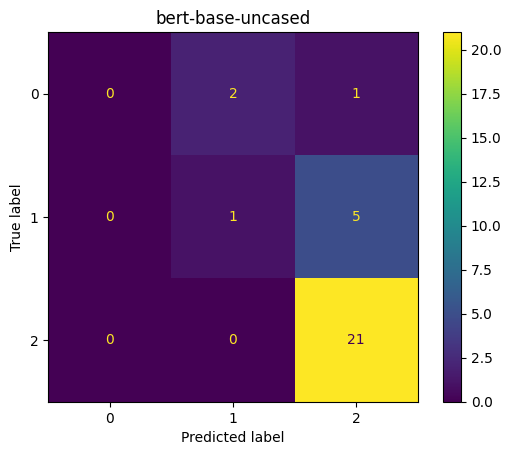


              precision    recall  f1-score   support

           0       0.00      0.00      0.00         3
           1       0.33      0.17      0.22         6
           2       0.78      1.00      0.88        21

    accuracy                           0.73        30
   macro avg       0.37      0.39      0.37        30
weighted avg       0.61      0.73      0.66        30



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
model_name = os.path.basename(CFG.model_name)
display_metrics(pred_data[TARGET], pred_data[f"{TARGET}_pred"].apply(clip_predictions), model_name)
log_metrics(calc_metrics(pred_data[f"{TARGET}_pred"].apply(clip_predictions), pred_data[TARGET]), model_name)

# GENSIM

## Train / test split

In [ ]:
PATH_TO_W2V_MODEL = "./word2vecmodel.bin"
NUM_FEATURES = 50

In [ ]:
X_train, y_train = prep_train_data(train_data, TARGET, INPUT_COL, PATH_TO_W2V_MODEL, num_features=NUM_FEATURES, window_size=10, min_count=40)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
X_test, y_test = prep_test_data(test_data, TARGET, INPUT_COL, PATH_TO_W2V_MODEL, num_features=NUM_FEATURES)

In [ ]:
print(f"Размер обучающей выборки после word2vec кодирования: {X_train.shape}")
print(f"Размер отложенной выборки после word2vec кодирования: {X_test.shape}")

Размер обучающей выборки после word2vec кодирования: (910, 50)
Размер отложенной выборки после word2vec кодирования: (30, 50)


## Линейная регрессия

In [ ]:
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = clip_predictions(model.predict(X_test))

Regression report:
rmse: 1.065
pearson_coeff: -0.114
spearman_coeff: -0.128
explained_variance: -1.081
kappa: -0.09



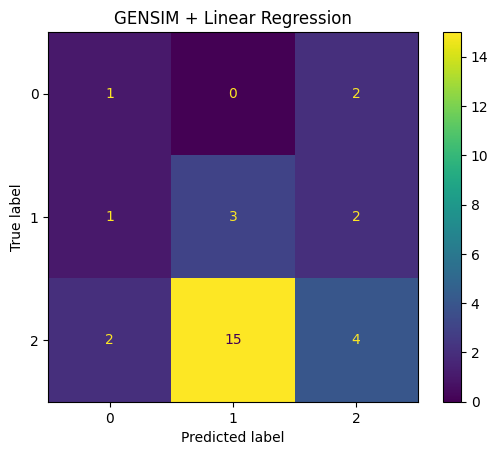


              precision    recall  f1-score   support

           0       0.25      0.33      0.29         3
           1       0.17      0.50      0.25         6
           2       0.50      0.19      0.28        21

    accuracy                           0.27        30
   macro avg       0.31      0.34      0.27        30
weighted avg       0.41      0.27      0.27        30



In [ ]:
model_name = "GENSIM + Linear Regression"
display_metrics(y_test, y_pred, model_name)
log_metrics(calc_metrics(y_pred, y_test), model_name)

## DecisionTree

In [ ]:
dt = DecisionTreeRegressor(random_state=RANDOM_STATE)
dt.fit(X_train, y_train)
y_pred = clip_predictions(dt.predict(X_test))

Regression report:
rmse: 1.225
pearson_coeff: -0.025
spearman_coeff: -0.03
explained_variance: -1.497
kappa: -0.018



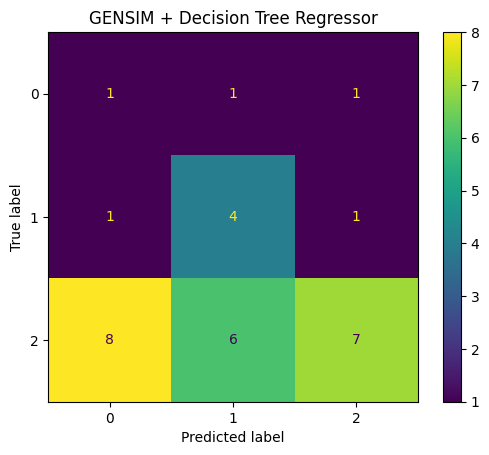


              precision    recall  f1-score   support

           0       0.10      0.33      0.15         3
           1       0.36      0.67      0.47         6
           2       0.78      0.33      0.47        21

    accuracy                           0.40        30
   macro avg       0.41      0.44      0.36        30
weighted avg       0.63      0.40      0.44        30



In [ ]:
model_name = "GENSIM + Decision Tree Regressor"
display_metrics(y_test, y_pred, model_name)
log_metrics(calc_metrics(y_pred, y_test), model_name)

## RandomForest

In [ ]:
rf = RandomForestRegressor(n_estimators=100, oob_score=True, random_state=RANDOM_STATE)
rf.fit(X_train, y_train)
y_pred = clip_predictions(rf.predict(X_test))

Regression report:
rmse: 1.049
pearson_coeff: 0.085
spearman_coeff: 0.131
explained_variance: -0.386
kappa: 0.046



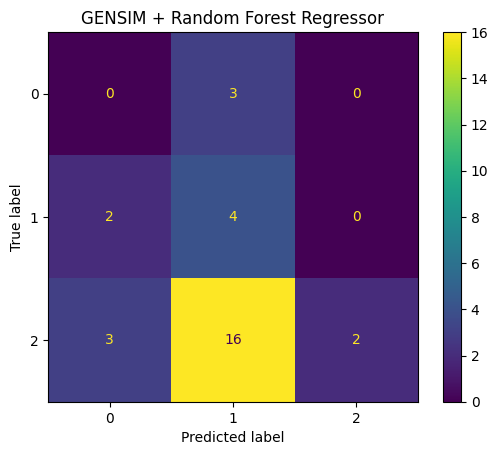


              precision    recall  f1-score   support

           0       0.00      0.00      0.00         3
           1       0.17      0.67      0.28         6
           2       1.00      0.10      0.17        21

    accuracy                           0.20        30
   macro avg       0.39      0.25      0.15        30
weighted avg       0.73      0.20      0.18        30



In [ ]:
model_name = "GENSIM + Random Forest Regressor"
display_metrics(y_test, y_pred, model_name)
log_metrics(calc_metrics(y_pred, y_test), model_name)

## SVM

In [ ]:
svm_regr = svm.SVR()
svm_regr.fit(X_train, y_train)
y_pred = clip_predictions(svm_regr.predict(X_test))

Regression report:
rmse: 1.08
pearson_coeff: -0.146
spearman_coeff: -0.089
explained_variance: -0.74
kappa: -0.087



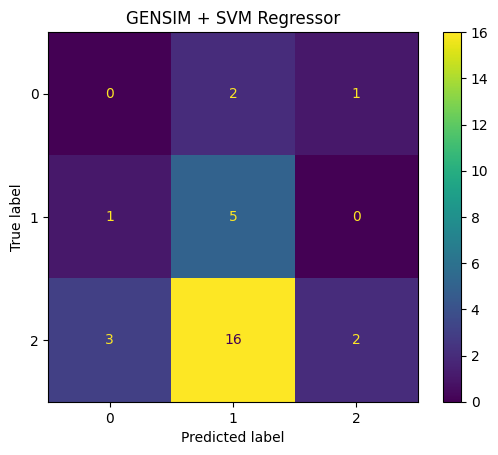


              precision    recall  f1-score   support

           0       0.00      0.00      0.00         3
           1       0.22      0.83      0.34         6
           2       0.67      0.10      0.17        21

    accuracy                           0.23        30
   macro avg       0.29      0.31      0.17        30
weighted avg       0.51      0.23      0.19        30



In [ ]:
model_name = "GENSIM + SVM Regressor"
display_metrics(y_test, y_pred, model_name)
log_metrics(calc_metrics(y_pred, y_test), model_name)

## XGBoost

In [ ]:
import xgboost as xgb

xgb_regr = xgb.XGBRegressor(objective="reg:squarederror", n_estimators=200)
xgb_regr.fit(X_train, y_train, verbose=True)
y_pred = clip_predictions(xgb_regr.predict(X_test))

Regression report:
rmse: 1.095
pearson_coeff: 0.018
spearman_coeff: 0.027
explained_variance: -0.717
kappa: 0.011



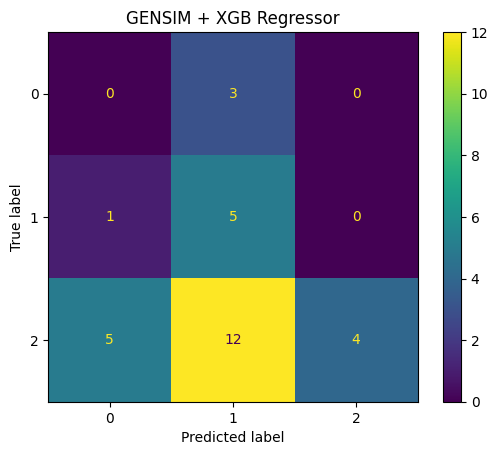


              precision    recall  f1-score   support

           0       0.00      0.00      0.00         3
           1       0.25      0.83      0.38         6
           2       1.00      0.19      0.32        21

    accuracy                           0.30        30
   macro avg       0.42      0.34      0.23        30
weighted avg       0.75      0.30      0.30        30



In [ ]:
model_name = "GENSIM + XGB Regressor"
display_metrics(y_test, y_pred, model_name)
log_metrics(calc_metrics(y_pred, y_test), model_name)

## LightGBM

In [ ]:
import lightgbm as lgb

lgb_regr = lgb.LGBMRegressor()
lgb_regr.fit(X_train, y_train)
y_pred = clip_predictions(lgb_regr.predict(X_test))

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000623 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12750
[LightGBM] [Info] Number of data points in the train set: 910, number of used features: 50
[LightGBM] [Info] Start training from score 1.065934


Regression report:
rmse: 1.155
pearson_coeff: -0.064
spearman_coeff: -0.068
explained_variance: -1.02
kappa: -0.042



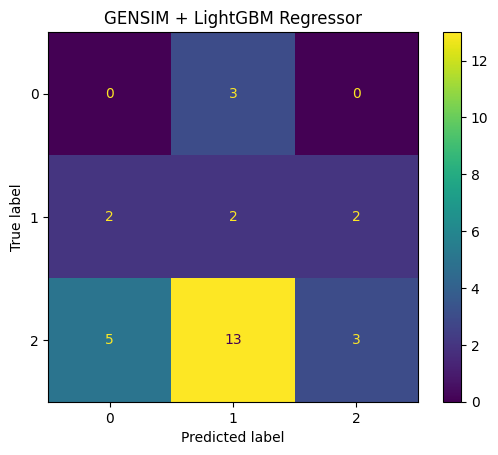


              precision    recall  f1-score   support

           0       0.00      0.00      0.00         3
           1       0.11      0.33      0.17         6
           2       0.60      0.14      0.23        21

    accuracy                           0.17        30
   macro avg       0.24      0.16      0.13        30
weighted avg       0.44      0.17      0.19        30



In [ ]:
model_name = "GENSIM + LightGBM Regressor"
display_metrics(y_test, y_pred, model_name)
log_metrics(calc_metrics(y_pred, y_test), model_name)

## CatBoost

In [ ]:
from catboost import CatBoostRegressor

catboost_regr = CatBoostRegressor()
catboost_regr.fit(X_train, y_train)
y_pred = clip_predictions(catboost_regr.predict(X_test))

Learning rate set to 0.040337
0:	learn: 0.7892136	total: 61.3ms	remaining: 1m 1s
1:	learn: 0.7804879	total: 71.3ms	remaining: 35.6s
2:	learn: 0.7729812	total: 81.8ms	remaining: 27.2s
3:	learn: 0.7652725	total: 92.4ms	remaining: 23s
4:	learn: 0.7574326	total: 103ms	remaining: 20.5s
5:	learn: 0.7503648	total: 113ms	remaining: 18.8s
6:	learn: 0.7438690	total: 124ms	remaining: 17.5s
7:	learn: 0.7380391	total: 138ms	remaining: 17.1s
8:	learn: 0.7320455	total: 148ms	remaining: 16.4s
9:	learn: 0.7267052	total: 159ms	remaining: 15.7s
10:	learn: 0.7212342	total: 172ms	remaining: 15.4s
11:	learn: 0.7160867	total: 182ms	remaining: 15s
12:	learn: 0.7108139	total: 193ms	remaining: 14.7s
13:	learn: 0.7067444	total: 208ms	remaining: 14.7s
14:	learn: 0.7021876	total: 219ms	remaining: 14.4s
15:	learn: 0.6978279	total: 234ms	remaining: 14.4s
16:	learn: 0.6938494	total: 245ms	remaining: 14.2s
17:	learn: 0.6898277	total: 256ms	remaining: 14s
18:	learn: 0.6860053	total: 267ms	remaining: 13.8s
19:	learn: 0.

Regression report:
rmse: 1.017
pearson_coeff: 0.147
spearman_coeff: 0.194
explained_variance: -0.437
kappa: 0.094



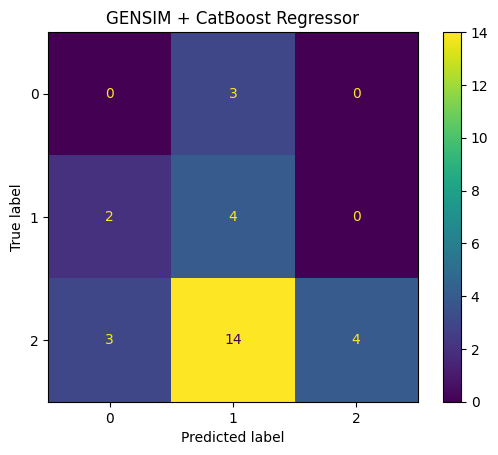


              precision    recall  f1-score   support

           0       0.00      0.00      0.00         3
           1       0.19      0.67      0.30         6
           2       1.00      0.19      0.32        21

    accuracy                           0.27        30
   macro avg       0.40      0.29      0.21        30
weighted avg       0.74      0.27      0.28        30



In [ ]:
model_name = "GENSIM + CatBoost Regressor"
display_metrics(y_test, y_pred, model_name)
log_metrics(calc_metrics(y_pred, y_test), model_name)

# TF-IDF

In [ ]:
X_train, y_train = train_data[INPUT_COL], train_data[TARGET]
X_test, y_test = test_data[INPUT_COL], test_data[TARGET]

In [ ]:
tfidf = TfidfVectorizer(min_df=5, max_df=1.0, ngram_range=(1, 1))
tfidf.fit(X_train)

TfidfVectorizer(min_df=5)

In [ ]:
X_train = tfidf.transform(X_train)
X_test = tfidf.transform(X_test)

print(f"Размер обучающей выборки после tf-idf кодирования: {X_train.shape}")
print(f"Размер отложенной выборки после tf-idf кодирования: {X_test.shape}")

Размер обучающей выборки после tf-idf кодирования: (910, 2255)
Размер отложенной выборки после tf-idf кодирования: (30, 2255)


## Линейная регрессия

In [ ]:
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = clip_predictions(model.predict(X_test))

Regression report:
rmse: 0.913
pearson_coeff: -0.108
spearman_coeff: -0.175
explained_variance: -0.891
kappa: -0.106



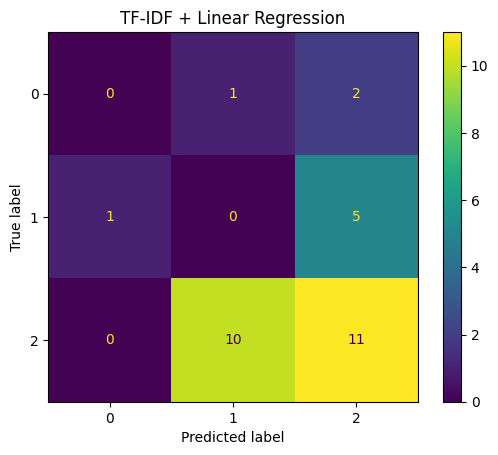


              precision    recall  f1-score   support

           0       0.00      0.00      0.00         3
           1       0.00      0.00      0.00         6
           2       0.61      0.52      0.56        21

    accuracy                           0.37        30
   macro avg       0.20      0.17      0.19        30
weighted avg       0.43      0.37      0.39        30



In [ ]:
model_name = "TF-IDF + Linear Regression"
display_metrics(y_test, y_pred, model_name)
log_metrics(calc_metrics(y_pred, y_test), model_name)

## DecisionTree

In [ ]:
dt = DecisionTreeRegressor(random_state=RANDOM_STATE)
dt.fit(X_train, y_train)
y_pred = clip_predictions(dt.predict(X_test))

Regression report:
rmse: 0.949
pearson_coeff: 0.215
spearman_coeff: 0.17
explained_variance: -0.922
kappa: 0.201



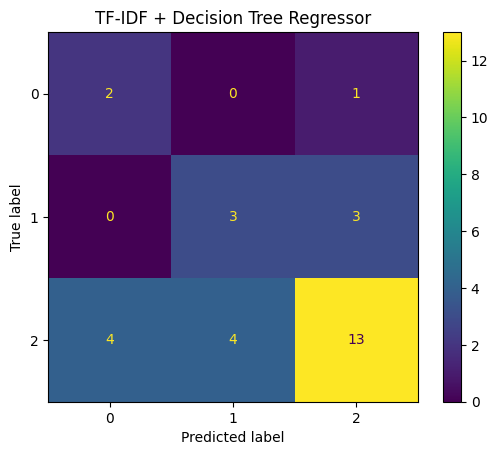


              precision    recall  f1-score   support

           0       0.33      0.67      0.44         3
           1       0.43      0.50      0.46         6
           2       0.76      0.62      0.68        21

    accuracy                           0.60        30
   macro avg       0.51      0.60      0.53        30
weighted avg       0.65      0.60      0.62        30



In [ ]:
model_name = "TF-IDF + Decision Tree Regressor"
display_metrics(y_test, y_pred, model_name)
log_metrics(calc_metrics(y_pred, y_test), model_name)

## RandomForest

In [ ]:
rf = RandomForestRegressor(n_estimators=150, oob_score=True, random_state=RANDOM_STATE)
rf.fit(X_train, y_train)
y_pred = clip_predictions(rf.predict(X_test))

Regression report:
rmse: 0.913
pearson_coeff: -0.02
spearman_coeff: 0.011
explained_variance: -0.588
kappa: -0.016



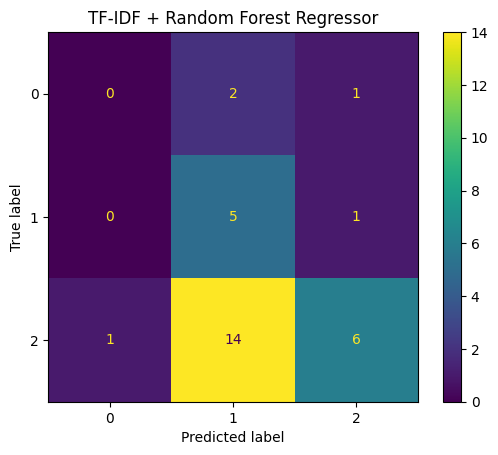


              precision    recall  f1-score   support

           0       0.00      0.00      0.00         3
           1       0.24      0.83      0.37         6
           2       0.75      0.29      0.41        21

    accuracy                           0.37        30
   macro avg       0.33      0.37      0.26        30
weighted avg       0.57      0.37      0.36        30



In [ ]:
model_name = "TF-IDF + Random Forest Regressor"
display_metrics(y_test, y_pred, model_name)
log_metrics(calc_metrics(y_pred, y_test), model_name)

## SVM

In [ ]:
svm_regr = svm.SVR()
svm_regr.fit(X_train, y_train)
y_pred = clip_predictions(svm_regr.predict(X_test))

Regression report:
rmse: 0.876
pearson_coeff: -0.044
spearman_coeff: -0.047
explained_variance: -0.538
kappa: -0.036



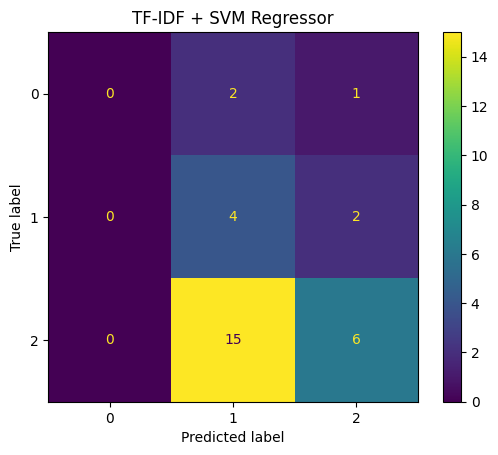


              precision    recall  f1-score   support

           0       0.00      0.00      0.00         3
           1       0.19      0.67      0.30         6
           2       0.67      0.29      0.40        21

    accuracy                           0.33        30
   macro avg       0.29      0.32      0.23        30
weighted avg       0.50      0.33      0.34        30



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
model_name = "TF-IDF + SVM Regressor"
display_metrics(y_test, y_pred, model_name)
log_metrics(calc_metrics(y_pred, y_test), model_name)

## XGBoost

In [ ]:
import xgboost as xgb

xgb_regr = xgb.XGBRegressor(objective="reg:squarederror", n_estimators=200)
xgb_regr.fit(X_train, y_train, verbose=True)
y_pred = clip_predictions(xgb_regr.predict(X_test))

Regression report:
rmse: 0.856
pearson_coeff: 0.054
spearman_coeff: 0.061
explained_variance: -0.626
kappa: 0.052



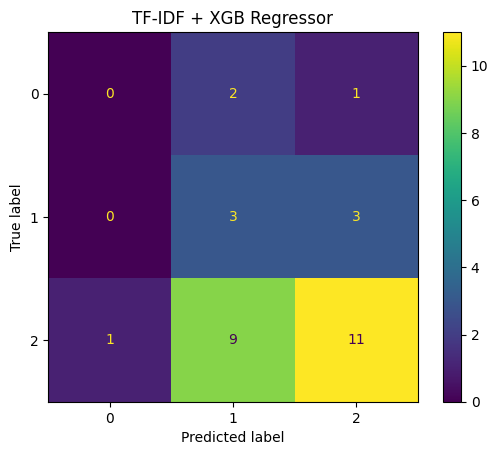


              precision    recall  f1-score   support

           0       0.00      0.00      0.00         3
           1       0.21      0.50      0.30         6
           2       0.73      0.52      0.61        21

    accuracy                           0.47        30
   macro avg       0.32      0.34      0.30        30
weighted avg       0.56      0.47      0.49        30



In [ ]:
model_name = "TF-IDF + XGB Regressor"
display_metrics(y_test, y_pred, model_name)
log_metrics(calc_metrics(y_pred, y_test), model_name)

## LightGBM

In [ ]:
import lightgbm as lgb

lgb_regr = lgb.LGBMRegressor()
lgb_regr.fit(X_train, y_train)
y_pred = clip_predictions(lgb_regr.predict(X_test))

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007424 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 33800
[LightGBM] [Info] Number of data points in the train set: 910, number of used features: 800
[LightGBM] [Info] Start training from score 1.065934


Regression report:
rmse: 0.876
pearson_coeff: -0.063
spearman_coeff: -0.089
explained_variance: -0.619
kappa: -0.055



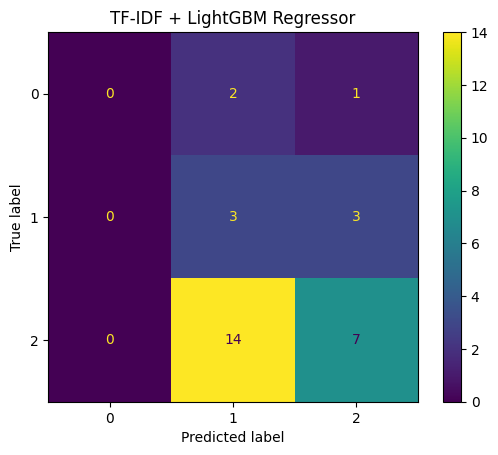


              precision    recall  f1-score   support

           0       0.00      0.00      0.00         3
           1       0.16      0.50      0.24         6
           2       0.64      0.33      0.44        21

    accuracy                           0.33        30
   macro avg       0.26      0.28      0.23        30
weighted avg       0.48      0.33      0.35        30



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
model_name = "TF-IDF + LightGBM Regressor"
display_metrics(y_test, y_pred, model_name)
log_metrics(calc_metrics(y_pred, y_test), model_name)

## CatBoost

In [ ]:
from catboost import CatBoostRegressor

catboost_regr = CatBoostRegressor()
catboost_regr.fit(X_train, y_train)
y_pred = clip_predictions(catboost_regr.predict(X_test))

Learning rate set to 0.040337
0:	learn: 0.7876513	total: 124ms	remaining: 2m 4s
1:	learn: 0.7773982	total: 218ms	remaining: 1m 48s
2:	learn: 0.7678975	total: 311ms	remaining: 1m 43s
3:	learn: 0.7593316	total: 402ms	remaining: 1m 40s
4:	learn: 0.7512569	total: 504ms	remaining: 1m 40s
5:	learn: 0.7433074	total: 595ms	remaining: 1m 38s
6:	learn: 0.7351398	total: 690ms	remaining: 1m 37s
7:	learn: 0.7279554	total: 786ms	remaining: 1m 37s
8:	learn: 0.7208482	total: 877ms	remaining: 1m 36s
9:	learn: 0.7130487	total: 998ms	remaining: 1m 38s
10:	learn: 0.7066008	total: 1.1s	remaining: 1m 38s
11:	learn: 0.7011951	total: 1.18s	remaining: 1m 37s
12:	learn: 0.6949073	total: 1.27s	remaining: 1m 36s
13:	learn: 0.6900748	total: 1.36s	remaining: 1m 35s
14:	learn: 0.6837764	total: 1.45s	remaining: 1m 35s
15:	learn: 0.6783801	total: 1.54s	remaining: 1m 34s
16:	learn: 0.6743563	total: 1.63s	remaining: 1m 34s
17:	learn: 0.6694963	total: 1.73s	remaining: 1m 34s
18:	learn: 0.6650843	total: 1.82s	remaining: 1

Regression report:
rmse: 0.856
pearson_coeff: -0.021
spearman_coeff: -0.044
explained_variance: -0.576
kappa: -0.019



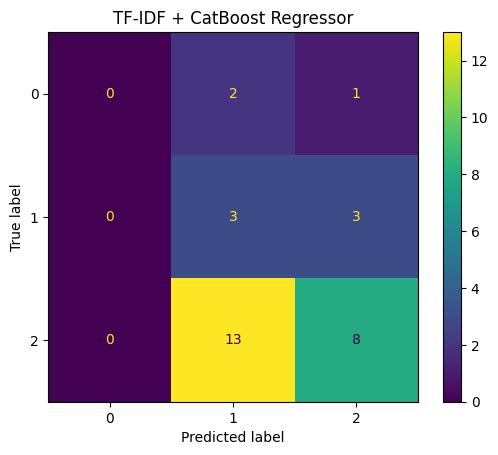


              precision    recall  f1-score   support

           0       0.00      0.00      0.00         3
           1       0.17      0.50      0.25         6
           2       0.67      0.38      0.48        21

    accuracy                           0.37        30
   macro avg       0.28      0.29      0.24        30
weighted avg       0.50      0.37      0.39        30



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
model_name = "TF-IDF + CatBoost Regressor"
display_metrics(y_test, y_pred, model_name)
log_metrics(calc_metrics(y_pred, y_test), model_name)

# GloVe

In [ ]:
!unzip /content/drive/MyDrive/movs_project/glove.42B.300d.zip

Archive:  /content/drive/MyDrive/movs_project/glove.42B.300d.zip
  inflating: glove.42B.300d.txt      


In [ ]:
embedding_vectors = {}
with open('./glove.42B.300d.txt', 'r', encoding='utf-8') as file:
    for row in file:
        values = row.split(' ')
        word = values[0]
        weights = np.asarray([float(val) for val in values[1:]])
        embedding_vectors[word] = weights

In [ ]:
X_train, y_train = glove_prep_data(train_data, TARGET, INPUT_COL, embedding_vectors)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
X_test, y_test = glove_prep_data(test_data, TARGET, INPUT_COL, embedding_vectors)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
print(f"Размер обучающей выборки после GloVe кодирования: {X_train.shape}")
print(f"Размер отложенной выборки после GloVe кодирования: {X_test.shape}")

Размер обучающей выборки после GloVe кодирования: (910, 300)
Размер отложенной выборки после GloVe кодирования: (30, 300)


## Линейная регрессия

In [ ]:
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = clip_predictions(model.predict(X_test))

Regression report:
rmse: 0.876
pearson_coeff: -0.146
spearman_coeff: -0.089
explained_variance: -0.74
kappa: -0.139



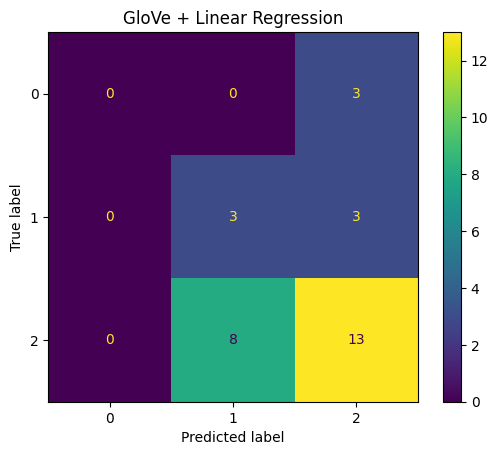


              precision    recall  f1-score   support

           0       0.00      0.00      0.00         3
           1       0.27      0.50      0.35         6
           2       0.68      0.62      0.65        21

    accuracy                           0.53        30
   macro avg       0.32      0.37      0.33        30
weighted avg       0.53      0.53      0.53        30



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
model_name = "GloVe + Linear Regression"
display_metrics(y_test, y_pred, model_name)
log_metrics(calc_metrics(y_pred, y_test), model_name)

## DecisionTree

In [ ]:
dt = DecisionTreeRegressor(random_state=RANDOM_STATE)
dt.fit(X_train, y_train)
y_pred = clip_predictions(dt.predict(X_test))

Regression report:
rmse: 1.0
pearson_coeff: 0.053
spearman_coeff: 0.017
explained_variance: -1.182
kappa: 0.051



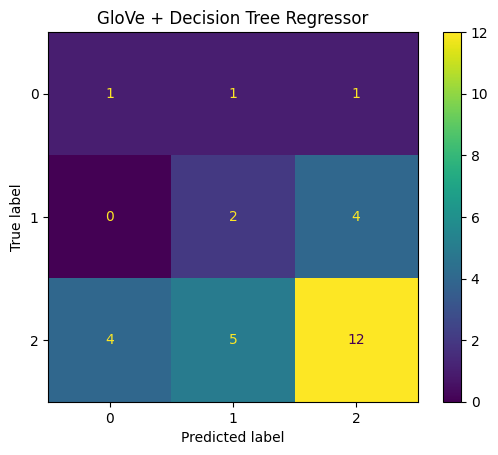


              precision    recall  f1-score   support

           0       0.20      0.33      0.25         3
           1       0.25      0.33      0.29         6
           2       0.71      0.57      0.63        21

    accuracy                           0.50        30
   macro avg       0.39      0.41      0.39        30
weighted avg       0.56      0.50      0.52        30



In [ ]:
model_name = "GloVe + Decision Tree Regressor"
display_metrics(y_test, y_pred, model_name)
log_metrics(calc_metrics(y_pred, y_test), model_name)

## RandomForest

In [ ]:
rf = RandomForestRegressor(n_estimators=100, oob_score=True, random_state=RANDOM_STATE)
rf.fit(X_train, y_train)
y_pred = clip_predictions(rf.predict(X_test))

Regression report:
rmse: 0.876
pearson_coeff: -0.063
spearman_coeff: -0.089
explained_variance: -0.619
kappa: -0.055



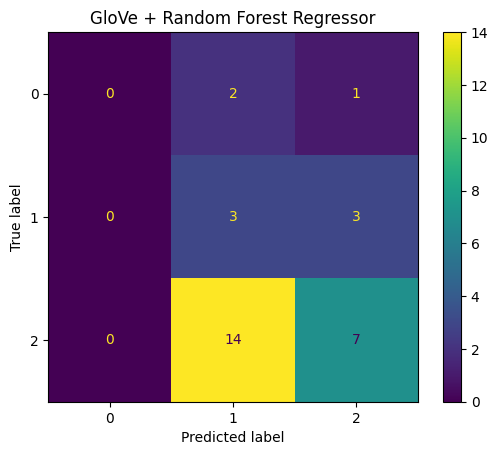


              precision    recall  f1-score   support

           0       0.00      0.00      0.00         3
           1       0.16      0.50      0.24         6
           2       0.64      0.33      0.44        21

    accuracy                           0.33        30
   macro avg       0.26      0.28      0.23        30
weighted avg       0.48      0.33      0.35        30



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
model_name = "GloVe + Random Forest Regressor"
display_metrics(y_test, y_pred, model_name)
log_metrics(calc_metrics(y_pred, y_test), model_name)

## SVM

In [ ]:
svm_regr = svm.SVR()
svm_regr.fit(X_train, y_train)
y_pred = clip_predictions(svm_regr.predict(X_test))

Regression report:
rmse: 0.913
pearson_coeff: -0.143
spearman_coeff: -0.153
explained_variance: -0.588
kappa: -0.106



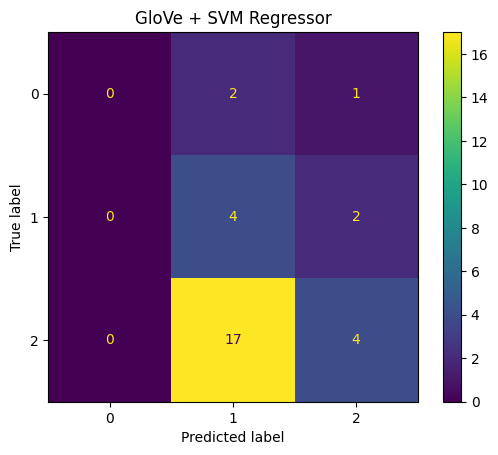


              precision    recall  f1-score   support

           0       0.00      0.00      0.00         3
           1       0.17      0.67      0.28         6
           2       0.57      0.19      0.29        21

    accuracy                           0.27        30
   macro avg       0.25      0.29      0.19        30
weighted avg       0.43      0.27      0.26        30



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
model_name = "GloVe + SVM Regressor"
display_metrics(y_test, y_pred, model_name)
log_metrics(calc_metrics(y_pred, y_test), model_name)

## XGBoost

In [ ]:
import xgboost as xgb

xgb_regr = xgb.XGBRegressor(objective="reg:squarederror", n_estimators=200)
xgb_regr.fit(X_train, y_train, verbose=True)
y_pred = clip_predictions(xgb_regr.predict(X_test))

Regression report:
rmse: 0.876
pearson_coeff: 0.018
spearman_coeff: 0.018
explained_variance: -0.679
kappa: 0.017



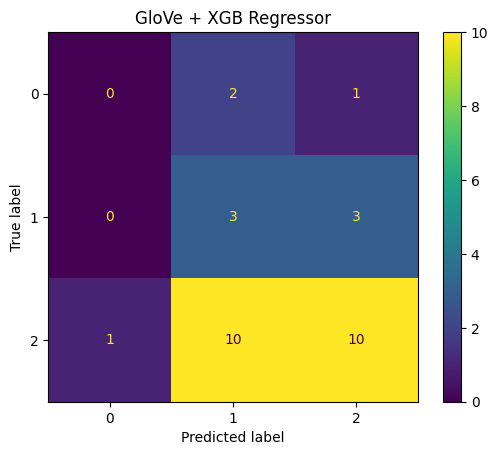


              precision    recall  f1-score   support

           0       0.00      0.00      0.00         3
           1       0.20      0.50      0.29         6
           2       0.71      0.48      0.57        21

    accuracy                           0.43        30
   macro avg       0.30      0.33      0.29        30
weighted avg       0.54      0.43      0.46        30



In [ ]:
model_name = "GloVe + XGB Regressor"
display_metrics(y_test, y_pred, model_name)
log_metrics(calc_metrics(y_pred, y_test), model_name)

## LightGBM

In [ ]:
import lightgbm as lgb

lgb_regr = lgb.LGBMRegressor()
lgb_regr.fit(X_train, y_train)
y_pred = clip_predictions(lgb_regr.predict(X_test))

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006385 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 76485
[LightGBM] [Info] Number of data points in the train set: 910, number of used features: 300
[LightGBM] [Info] Start training from score 1.065934


Regression report:
rmse: 0.837
pearson_coeff: 0.02
spearman_coeff: 0.0
explained_variance: -0.528
kappa: 0.019



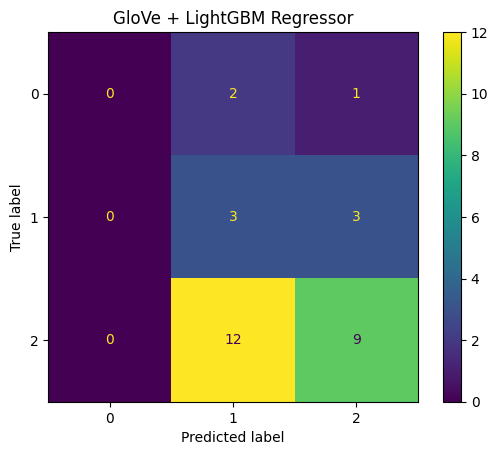


              precision    recall  f1-score   support

           0       0.00      0.00      0.00         3
           1       0.18      0.50      0.26         6
           2       0.69      0.43      0.53        21

    accuracy                           0.40        30
   macro avg       0.29      0.31      0.26        30
weighted avg       0.52      0.40      0.42        30



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
model_name = "GloVe + LightGBM Regressor"
display_metrics(y_test, y_pred, model_name)
log_metrics(calc_metrics(y_pred, y_test), model_name)

## CatBoost

In [ ]:
from catboost import CatBoostRegressor

catboost_regr = CatBoostRegressor()
catboost_regr.fit(X_train, y_train)
y_pred = clip_predictions(catboost_regr.predict(X_test))

Learning rate set to 0.040337
0:	learn: 0.7872614	total: 133ms	remaining: 2m 12s
1:	learn: 0.7765189	total: 223ms	remaining: 1m 51s
2:	learn: 0.7657535	total: 314ms	remaining: 1m 44s
3:	learn: 0.7563624	total: 397ms	remaining: 1m 38s
4:	learn: 0.7480439	total: 486ms	remaining: 1m 36s
5:	learn: 0.7373879	total: 571ms	remaining: 1m 34s
6:	learn: 0.7287324	total: 654ms	remaining: 1m 32s
7:	learn: 0.7199067	total: 737ms	remaining: 1m 31s
8:	learn: 0.7107054	total: 822ms	remaining: 1m 30s
9:	learn: 0.7019189	total: 908ms	remaining: 1m 29s
10:	learn: 0.6946580	total: 1.01s	remaining: 1m 30s
11:	learn: 0.6879778	total: 1.09s	remaining: 1m 29s
12:	learn: 0.6800448	total: 1.17s	remaining: 1m 28s
13:	learn: 0.6729306	total: 1.25s	remaining: 1m 28s
14:	learn: 0.6662875	total: 1.34s	remaining: 1m 27s
15:	learn: 0.6597755	total: 1.42s	remaining: 1m 27s
16:	learn: 0.6531602	total: 1.5s	remaining: 1m 26s
17:	learn: 0.6474777	total: 1.58s	remaining: 1m 26s
18:	learn: 0.6416875	total: 1.66s	remaining: 

Regression report:
rmse: 0.796
pearson_coeff: 0.081
spearman_coeff: 0.043
explained_variance: -0.437
kappa: 0.078



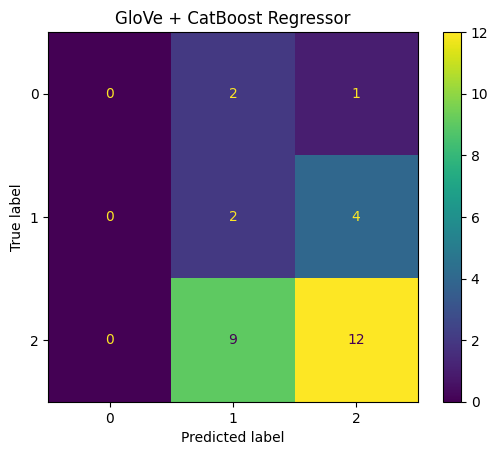


              precision    recall  f1-score   support

           0       0.00      0.00      0.00         3
           1       0.15      0.33      0.21         6
           2       0.71      0.57      0.63        21

    accuracy                           0.47        30
   macro avg       0.29      0.30      0.28        30
weighted avg       0.52      0.47      0.48        30



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
model_name = "GloVe + CatBoost Regressor"
display_metrics(y_test, y_pred, model_name)
log_metrics(calc_metrics(y_pred, y_test), model_name)

# DummyRegressor

In [ ]:
dummy_regr = DummyRegressor(strategy="constant", constant=2)
dummy_regr.fit(X_train, y_train)
y_pred = clip_predictions(dummy_regr.predict(X_test))

/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


Regression report:
rmse: 0.775
pearson_coeff: nan
spearman_coeff: nan
explained_variance: -0.0
kappa: 0.0



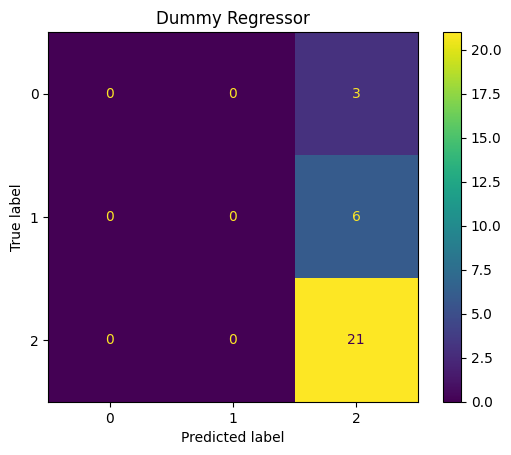


              precision    recall  f1-score   support

           0       0.00      0.00      0.00         3
           1       0.00      0.00      0.00         6
           2       0.70      1.00      0.82        21

    accuracy                           0.70        30
   macro avg       0.23      0.33      0.27        30
weighted avg       0.49      0.70      0.58        30



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.

In [ ]:
model_name = "Dummy Regressor"
display_metrics(y_test, y_pred, model_name)
log_metrics(calc_metrics(y_pred, y_test), model_name)

In [ ]:
metrics_old = pd.read_excel("/content/drive/MyDrive/movs_project/df_metrics.xlsx", index_col=0)

In [ ]:
DF_METRICS = pd.concat([metrics_old.loc[14, :].to_frame().T, DF_METRICS], axis=0, ignore_index=True)

In [ ]:
DF_METRICS = DF_METRICS.drop(["rmse", "pearson_coeff", "spearman_coeff", "explained_variance", "kappa", "model_name"], axis=0)
DF_METRICS = DF_METRICS.drop([14], axis=1)

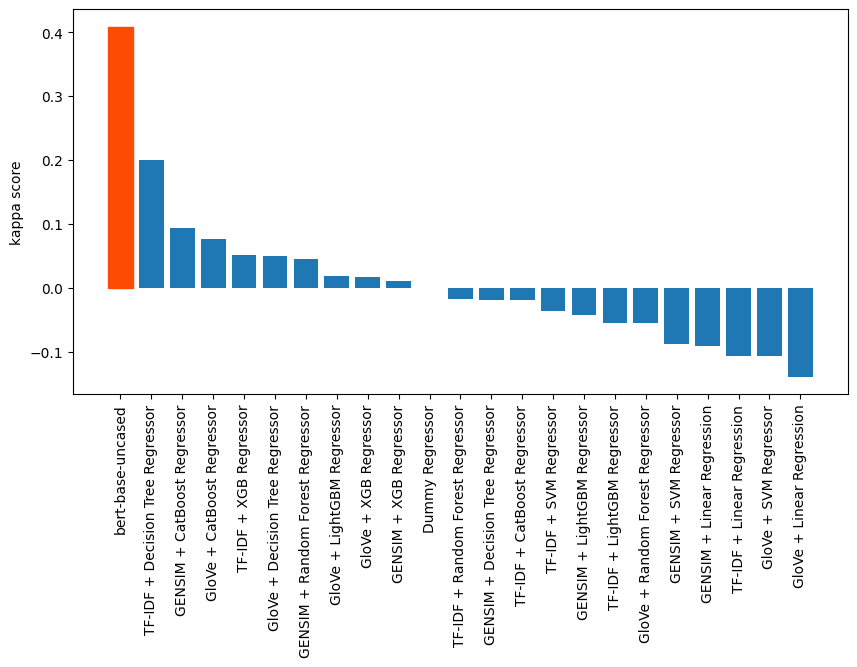

In [ ]:
plt.figure(figsize=(10, 5))
DF_METRICS = DF_METRICS.sort_values("kappa", ascending=False)
barlist = plt.bar(DF_METRICS["model_name"], DF_METRICS["kappa"])
plt.xticks(rotation=90)
barlist[0].set_color('xkcd:blood orange')
plt.ylabel("kappa score")
# plt.show()
plt.savefig("models_metrics.png", transparent=True, bbox_inches="tight", dpi=300)